In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
base_dir = 'Archive'
train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')


In [5]:
def prepare_binary_folders():
    print("Preparing binary folders...")
    tumor_folders = ['glioma', 'meningioma', 'pituitary']

    for split in ['training', 'testing']:
        split_path = os.path.join(base_dir, split)
        tumor_path = os.path.join(split_path, 'tumor')
        notumor_path = os.path.join(split_path, 'notumor')
        os.makedirs(tumor_path, exist_ok=True)
        os.makedirs(notumor_path, exist_ok=True)

        for t in tumor_folders:
            old_path = os.path.join(split_path, t)
            if os.path.exists(old_path):
                # move images to tumor folder
                for f in os.listdir(old_path):
                    src = os.path.join(old_path, f)
                    dst = os.path.join(tumor_path, f)
                    shutil.move(src, dst)
                shutil.rmtree(old_path)
    print("Done.")

prepare_binary_folders()

Preparing binary folders...
Done.


In [7]:
img_size = 64  
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   zoom_range=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['notumor', 'tumor'])

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    classes=['notumor', 'tumor'],
    shuffle=False)

print("Classes:", train_generator.class_indices)

Found 5221 images belonging to 2 classes.
Found 1311 images belonging to 2 classes.
Classes: {'notumor': 0, 'tumor': 1}


In [9]:

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size,img_size,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\compu market\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=test_generator)

C:\Users\compu market\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.7979 - loss: 0.4311 - val_accuracy: 0.6285 - val_loss: 0.8774
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 24s 147ms/step - accuracy: 0.9288 - loss: 0.1938 - val_accuracy: 0.7872 - val_loss: 0.5573
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.9468 - loss: 0.1623 - val_accuracy: 0.7216 - val_loss: 0.7322
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9537 - loss: 0.1380 - val_accuracy: 0.7750 - val_loss: 0.5304
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.9617 - loss: 0.1161 - val_accuracy: 0.8505 - val_loss: 0.3786
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9506 - loss: 0.1246 - val_accuracy: 0.8741 - val_loss: 0.3232
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9685 - loss: 0.1055 - val_accuracy: 0.5294 - val_loss: 1.1633
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9578 - loss: 0

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9609 - loss: 0.1211
Test Accuracy: 94.28%
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


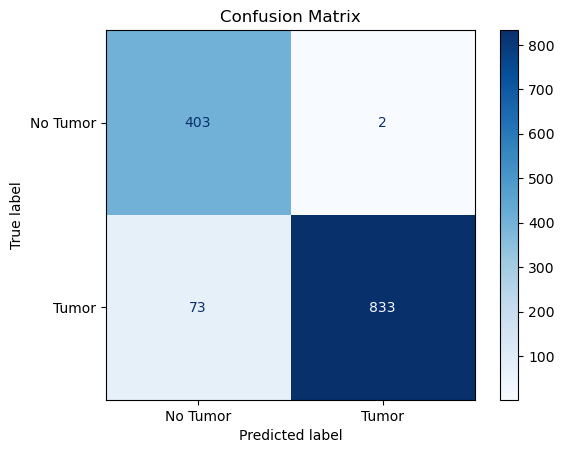

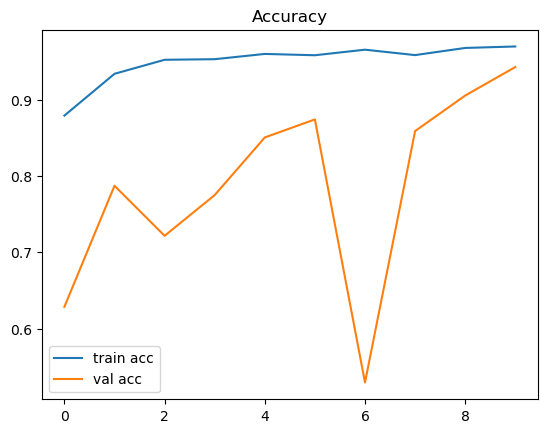

In [13]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

y_true = test_generator.classes
y_prob = model.predict(test_generator)
y_pred = (y_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor','Tumor'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()


In [15]:
model.save('brain_tumor_model.h5')
print("Model saved as brain_tumor_model.h5")


Model saved as brain_tumor_model.h5
